<a href="https://colab.research.google.com/github/Surya291/WiFi_Sensing_2.0/blob/master/Code/Expt2/exp2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import math
import sys
import json
import argparse
import pandas as pd
import numpy as np
import scipy.signal as signal
from sklearn import decomposition, preprocessing  
from mpl_toolkits.mplot3d import Axes3D  
import matplotlib.pyplot as plt
from numba import jit
import plotly.express as px


In [4]:
df = pd.read_csv(
    '/home/kuntal990/projects/WiFi_Sensing_2.0/dataset/CSI_DATA/d1.csv')
print(df.columns)


Index(['type', 'role', 'mac', 'rssi', 'rate', 'sig_mode', 'mcs', 'bandwidth',
       'smoothing', 'not_sounding', 'aggregation', 'stbc', 'fec_coding', 'sgi',
       'noise_floor', 'ampdu_cnt', 'channel', 'secondary_channel',
       'local_timestamp', 'ant', 'sig_len', 'rx_state', 'real_time_set',
       'real_timestamp', 'len', 'CSI_DATA'],
      dtype='object')


      rssi
0      -59
1      -59
2      -57
3      -58
4      -61
...    ...
5210   -69
5211   -68
5212   -67
5213   -68
5214   -69

[5215 rows x 1 columns]
      real_timestamp
0           0.303156
1           0.316786
2           1.187859
3           1.201195
4           1.211800
...              ...
5210       91.896187
5211       91.906979
5212       91.917229
5213       91.927868
5214       91.938475

[5215 rows x 1 columns]


Text(0, 0.5, 'rssi magnitude')

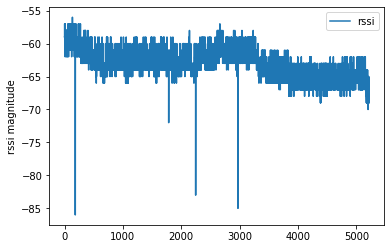

In [5]:
df_rssi = df.loc[:,['rssi']]
df_time = df.loc[:, ['real_timestamp']]
print(df_rssi)
print(df_time)
df_rssi.plot(y=['rssi'])
#plt.axis([0, len(df_rssi.index), -72, -45])
#plt.plot(df_time['real_timestamp'], df_rssi['rssi'])
plt.ylabel('rssi magnitude')

In [6]:
df_csi = df.loc[:, ['len', 'CSI_DATA']]
drop_idx = []
for i in range(df_csi.shape[0]):
  if df_csi.iloc[i]['len'] < 384:
    drop_idx.append(i)

df_csi = df_csi.drop(drop_idx)
size_x = len(df_csi.index)
size_y = df_csi.iloc[0]['len']//2 # no. of subcarriers ..

array_csi = np.zeros([size_x, size_y], dtype = np.complex64)

for x , csi in enumerate(df_csi.iloc):
    temp = csi["CSI_DATA"].replace(' ', ',')
    temp = temp.replace(',]', ']')
    csi_raw_data = json.loads(temp)
    for y in range(0, len(csi_raw_data), 2):
        array_csi[x][y//2] = complex(csi_raw_data[y], csi_raw_data[y + 1])  # IQ channel frequency response



In [7]:
size_y

192

In [8]:
time_0 = df_time.iloc[0]['real_timestamp']
time_n = df_time.iloc[-1]['real_timestamp']
print(time_n)

91.938475


(4755, 192)
26


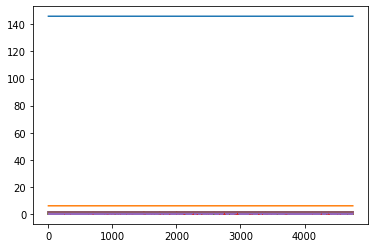

In [9]:
array_csi_modulus = abs(array_csi)  # amplitude calculating
print(array_csi_modulus.shape)

drop_idx = []

for i in range(array_csi_modulus.shape[1]):
  if (np.var(array_csi_modulus[:, i]) < 1):
    drop_idx.append(i)



print(len(drop_idx))

for i in (drop_idx):
  plt.plot(array_csi_modulus[:, i])

#Only 52 sub-carriers have meaning full data

In [ ]:
select_list = [i for i in range(size_y)]


for i in drop_idx:
  select_list.remove(i)

LLTF = []
HTLTF = []
for i in select_list:
  if i < 64:
    LLTF.append(i)
  elif 64 <= i < 128:
    HTLTF.append(i)

In [ ]:
time_0

0.30288200000000004

         sub0  sub1  sub2  sub3  ...     sub189     sub190    sub191  timestamp
0  164.878738   8.0   0.0   0.0  ...  39.204590  22.203604  1.414214          0
1   23.345236  14.0   0.0   0.0  ...  33.241539  18.867962  1.414214          1
2  126.253716   4.0   0.0   0.0  ...  30.463093  24.207438  1.414214          2
3  146.000000   6.0   0.0   0.0  ...  31.112698  29.154760  1.414214          3
4  146.000000   6.0   0.0   0.0  ...  28.160255  31.112698  1.414214          4

[5 rows x 193 columns]


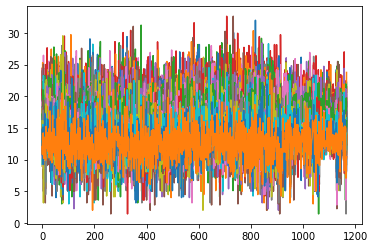

In [ ]:
columns = [f'sub{i}' for i in range(0, size_y)]
df_csi_modulus = pd.DataFrame(array_csi_modulus, columns=columns)
df_csi_modulus['timestamp'] = np.arange(size_x)
print(df_csi_modulus.head())
fig = px.line(df_csi_modulus)
fig.show()
df_csi_modulus.plot(y = [i for i in LLTF[1:]], legend=False)

plt.show()

# df_csi_modulus.plot(y = [i for i in HTLTF], legend=False)
# plt.show()

In [ ]:
#@jit(nopython=False)
def hampel_filter(input_series, window_size, n_sigmas=3):
    n = 5800
    new_series = input_series.copy()
    k = 1.4826 # scale factor for Gaussian distribution
    indices = []
    
    for i in range((window_size),(n - window_size)):
        x0 = np.nanmedian(input_series[(i - window_size):(i + window_size)])
        S0 = k * np.nanmedian(np.abs(input_series[(i - window_size):(i + window_size)] - x0))
        if (np.abs(input_series[i] - x0) > n_sigmas * S0):
            new_series[i] = x0
            indices.append(i)
    
    return new_series, indices



In [ ]:
df_csi_modulus= (df_csi_modulus.drop(drop_idx, axis=1))
print(df_csi_modulus.columns)

In [ ]:
print(df_csi_modulus)

             6          7          8   ...         56         57         58
0     17.117243  17.117243  18.248287  ...  18.110771  17.464249  17.117243
1     18.000000  19.026299  20.000000  ...  21.000000  20.223749  20.099751
2     16.000000  16.031219  17.029387  ...  16.000000  16.124516  16.031219
3     18.384777  17.088007  19.313208  ...  17.492855  17.464249  17.000000
4     17.262676  16.278820  17.262676  ...  16.000000  16.124516  16.031219
...         ...        ...        ...  ...        ...        ...        ...
5795  11.045361  12.165525  14.035668  ...  16.031219  17.000000  17.000000
5796  11.045361  12.165525  14.035668  ...  16.031219  17.000000  17.000000
5797  11.045361  12.165525  14.035668  ...  16.031219  17.000000  17.000000
5798  12.649111  12.369317  13.341664  ...  16.492422  16.278820  16.278820
5799  12.649111  12.369317  13.341664  ...  16.492422  16.278820  16.278820

[5800 rows x 52 columns]


In [ ]:
print(df_csi_modulus.shape)
csi_mod = df_csi_modulus.copy()
csi_mod = csi_mod.to_numpy()
print(csi_mod.shape)

(5800, 52)
(5800, 52)


In [ ]:
def normalize(csi_array):
    """ normalize all amplitudes into [0, 1]
    :param csi_array:
    :return: normalized csi amplitude array
    """
    array_csi_modulus = preprocessing.scale(csi_array)
    standardScalar = preprocessing.MinMaxScaler()
    standardScalar.fit(array_csi_modulus)
    array_csi_normalized = standardScalar.transform(array_csi_modulus)

    return array_csi_normalized


def decompose(array_csi_modulus, dimensions):
    """decomposition
    :param array_csi_modulus: normalized csi amplitude array
    :param dimensions: the shape you decompose the data
    :return:
    """
    pca = decomposition.FastICA(n_components=dimensions)  # FA, FICA, MBDL
    CSI = pca.fit_transform(array_csi_modulus)
    CSI = normalize(CSI)
    return CSI

def hampel(X):
    """ hampel filter to remove outliers
    :param :one of the wifi packet with all real and imag of subcarriers
    :return:wifi packets after removing outliers
    """
    length = X.shape[0] - 1
    k = 3
    nsigma = 3
    iLo = np.array([i - k for i in range(0, length + 1)])
    iHi = np.array([i + k for i in range(0, length + 1)])
    iLo[iLo < 0] = 0
    iHi[iHi > length] = length
    xmad = []
    xmedian = []
    for i in range(length + 1):
        w = X[iLo[i]:iHi[i] + 1]
        medj = np.median(w)
        mad = np.median(np.abs(w - medj))
        xmad.append(mad)
        xmedian.append(medj)
    xmad = np.array(xmad)
    xmedian = np.array(xmedian)
    scale = 1.4826  # 缩放
    xsigma = scale * xmad
    xi = ~(np.abs(X - xmedian) <= nsigma * xsigma)  # 找出离群点（即超过nsigma个标准差）

    # 将离群点替换为中为数值
    xf = X.copy()
    xf[xi] = xmedian[xi]
    return xf

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

SC = StandardScaler()
csi_mod_2 = SC.fit_transform(csi_mod)
pca = PCA(n_components=6)
PC = pca.fit_transform(csi_mod_2)
#PC = SC.fit_transform(PC)

In [ ]:
print(PC.shape)

(5800, 6)


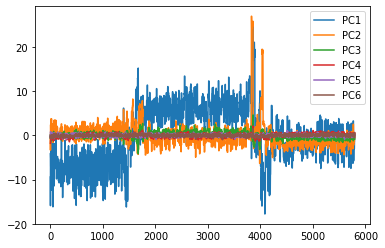

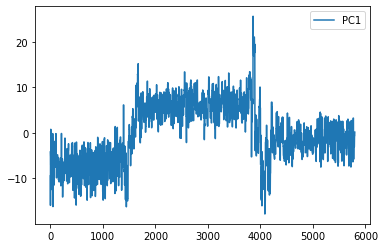

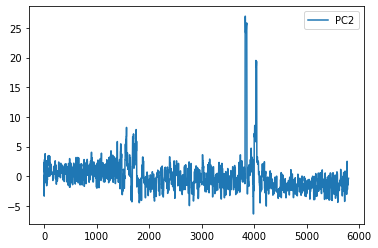

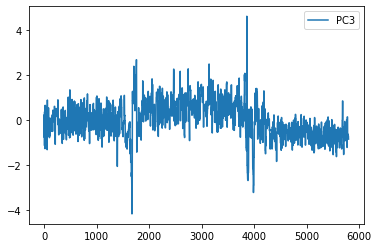

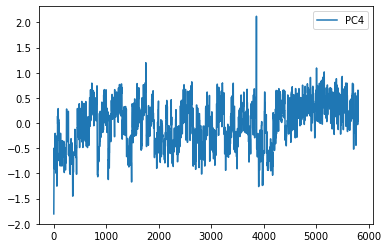

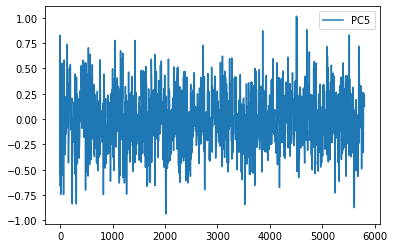

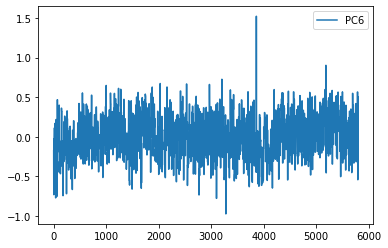

In [ ]:
columns = [f'PC{i+1}' for i in range(6)]
df_PC = pd.DataFrame(PC, columns=columns)

df_PC.plot()
for i in range(6):
  df_PC.plot(y=[i])